## 1. Tree-Based Methods

Import packages

In [5]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### (a) Download the APS Failure data

In [7]:
train_path = '../data/aps_failure_training_set.csv'
test_path = '../data/aps_failure_test_set.csv'

train_data = pd.read_csv(train_path, skiprows=20, na_values='na')
test_data = pd.read_csv(test_path, skiprows=20, na_values='na')

train_data['class'] = train_data['class'].map({'neg': 0, 'pos': 1})
test_data['class'] = test_data['class'].map({'neg': 0, 'pos': 1})

print("Training Data Size:", train_data.shape)
print("Testing Data Size:", test_data.shape)

Training Data Size: (60000, 171)
Testing Data Size: (16000, 171)


In [8]:
X_train = train_data.drop(columns='class')
y_train = train_data['class']
X_test = test_data.drop(columns='class')
y_test = test_data['class']

imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("Imputed Training Features Size:", X_train_imputed.shape)
print("Imputed Testing Features Size:", X_test_imputed.shape)

Imputed Training Features Size: (60000, 170)
Imputed Testing Features Size: (16000, 170)


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

When dealing with missing data, there are several common imputation techniques:

1.Mean, Median, or Mode Imputation: Replacing missing values with the mean, median, or mode of each feature.

2.K-Nearest Neighbors (KNN) Imputation: Using the values of the nearest neighbors to predict missing values.

3.Predictive Modeling: Creating a model to predict missing values based on the relationships between other features.

4.Multiple Imputation: Generating several possible values for each missing data point and averaging results.

5.Forward/Backward Fill: Often used in time-series data, where missing values are filled based on previous or following observations.

For this task, Mean Imputation is being applied.

#### (ii) Calculate the coefficient of variation

In [13]:
cv_metrics = {}

for feature in X_train_imputed.columns:
    mean_val = X_train_imputed[feature].mean()
    std_dev = X_train_imputed[feature].std()
    
    cv = std_dev / mean_val if mean_val != 0 else 0  
    
    cv_metrics[feature] = {'mean': mean_val, 'std_dev': std_dev, 'cv': cv}

cv_df = pd.DataFrame(cv_metrics).T  
cv_df.columns = ['Mean', 'Standard Deviation', 'Coefficient of Variation']
cv_df


,Mean,Standard Deviation,Coefficient of Variation
aa_000,5.933650e+04,1.454301e+05,2.450938
ab_000,7.131885e-01,1.660588e+00,2.328400
ac_000,3.560143e+08,7.724678e+08,2.169767
ad_000,1.906206e+05,3.504515e+07,183.847620
ae_000,6.819130e+00,1.581420e+02,23.190937
...,...,...,...
ee_007,3.462714e+05,1.718366e+06,4.962483
ee_008,1.387300e+05,4.469894e+05,3.222010
ee_009,8.388915e+03,4.720424e+04,5.626979
ef_000,9.057895e-02,4.268529e+00,47.124953


#### (iii) Plot a correlation matrix

In [15]:
correlation_matrix = X_train_imputed.corr()
correlation_matrix

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.029905,-0.020777,-0.001110,0.046259,0.066789,0.018541,0.142624,0.284759,0.493699,...,0.732465,0.736337,0.715019,0.724412,0.724157,0.603875,0.469873,0.247075,0.014128,0.026386
ab_000,0.029905,1.000000,-0.009774,0.000068,0.028885,0.044009,0.000588,0.006949,0.022347,0.034921,...,0.022974,0.038026,0.028289,0.025605,0.023169,0.011406,0.002352,0.000619,0.051710,0.104345
ac_000,-0.020777,-0.009774,1.000000,-0.002285,-0.004944,-0.010270,0.017524,-0.000671,-0.008976,-0.023478,...,-0.009280,-0.005859,-0.007236,-0.006898,-0.014152,-0.019008,0.011781,0.019416,-0.006165,0.014228
ad_000,-0.001110,0.000068,-0.002285,1.000000,-0.000209,-0.000257,-0.000047,-0.000055,-0.000119,-0.000276,...,-0.001015,-0.001057,-0.001046,-0.000848,-0.000862,-0.000518,-0.000932,-0.000578,-0.000095,-0.000114
ae_000,0.046259,0.028885,-0.004944,-0.000209,1.000000,0.823108,-0.000428,-0.000589,0.003214,0.024237,...,0.012989,0.019364,0.013754,0.028607,0.063056,0.037821,-0.008457,-0.006774,0.070835,0.041685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.603875,0.011406,-0.019008,-0.000518,0.037821,0.050743,0.000307,0.044161,0.182666,0.505081,...,0.454833,0.446803,0.437682,0.379892,0.545929,1.000000,0.224938,0.061478,-0.000498,0.001841
ee_008,0.469873,0.002352,0.011781,-0.000932,-0.008457,-0.010884,-0.000823,0.004875,0.009449,0.021131,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,1.000000,0.710056,-0.005422,-0.002200
ee_009,0.247075,0.000619,0.019416,-0.000578,-0.006774,-0.008442,-0.001230,-0.004307,-0.009481,-0.019292,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,0.710056,1.000000,-0.003256,-0.000750
ef_000,0.014128,0.051710,-0.006165,-0.000095,0.070835,0.106271,-0.000072,0.002032,0.007393,0.013960,...,0.005132,0.013148,0.004479,0.033649,0.005946,-0.000498,-0.005422,-0.003256,1.000000,0.282184


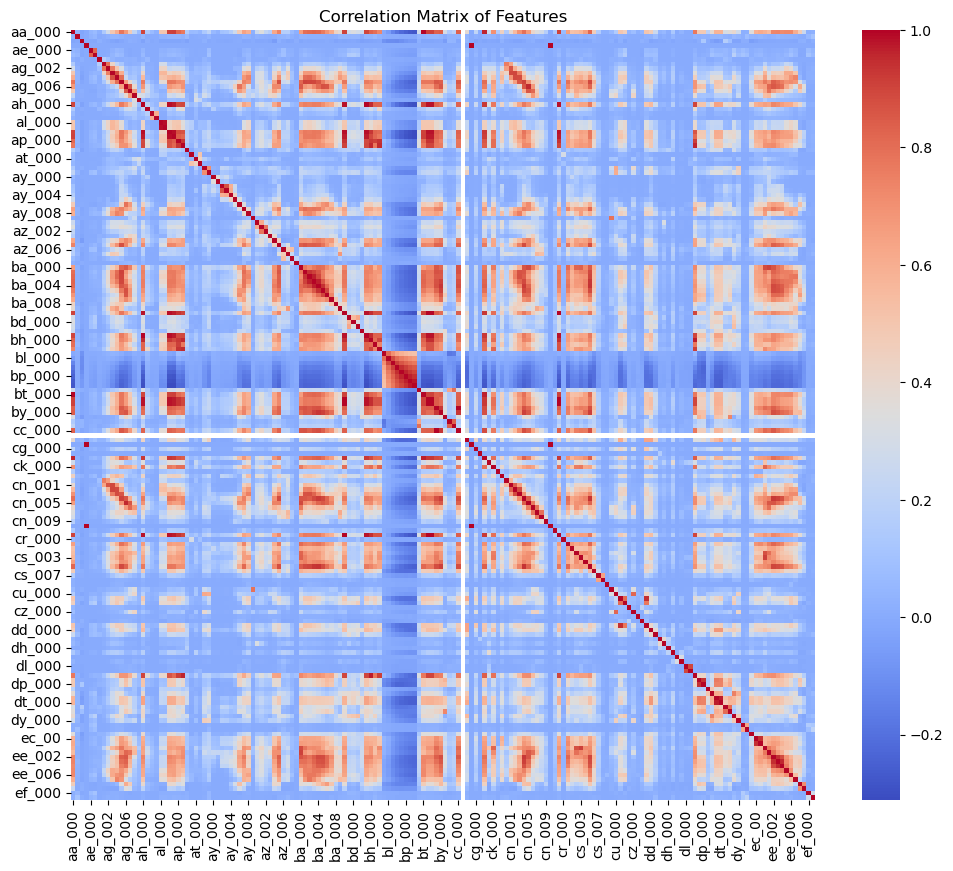

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Features")
plt.show()


#### (iv) Make scatter plots and box plots

In [18]:
num_features = int(math.sqrt(len(cv_df)))

cv_sorted = cv_df.sort_values(by='Coefficient of Variation', ascending=False)

top_features = cv_sorted.head(num_features).index

print("Selected Features Based on CV:")
print(cv_df.loc[top_features, ['Coefficient of Variation']])


Selected Features Based on CV:
        Coefficient of Variation
cs_009                235.277605
cf_000                184.233092
co_000                183.949017
ad_000                183.847620
dh_000                114.984991
dj_000                109.647285
ag_000                 91.878565
as_000                 86.416904
ay_009                 83.786063
az_009                 76.967978
ak_000                 74.526688
au_000                 68.160554
ch_000                 58.268229


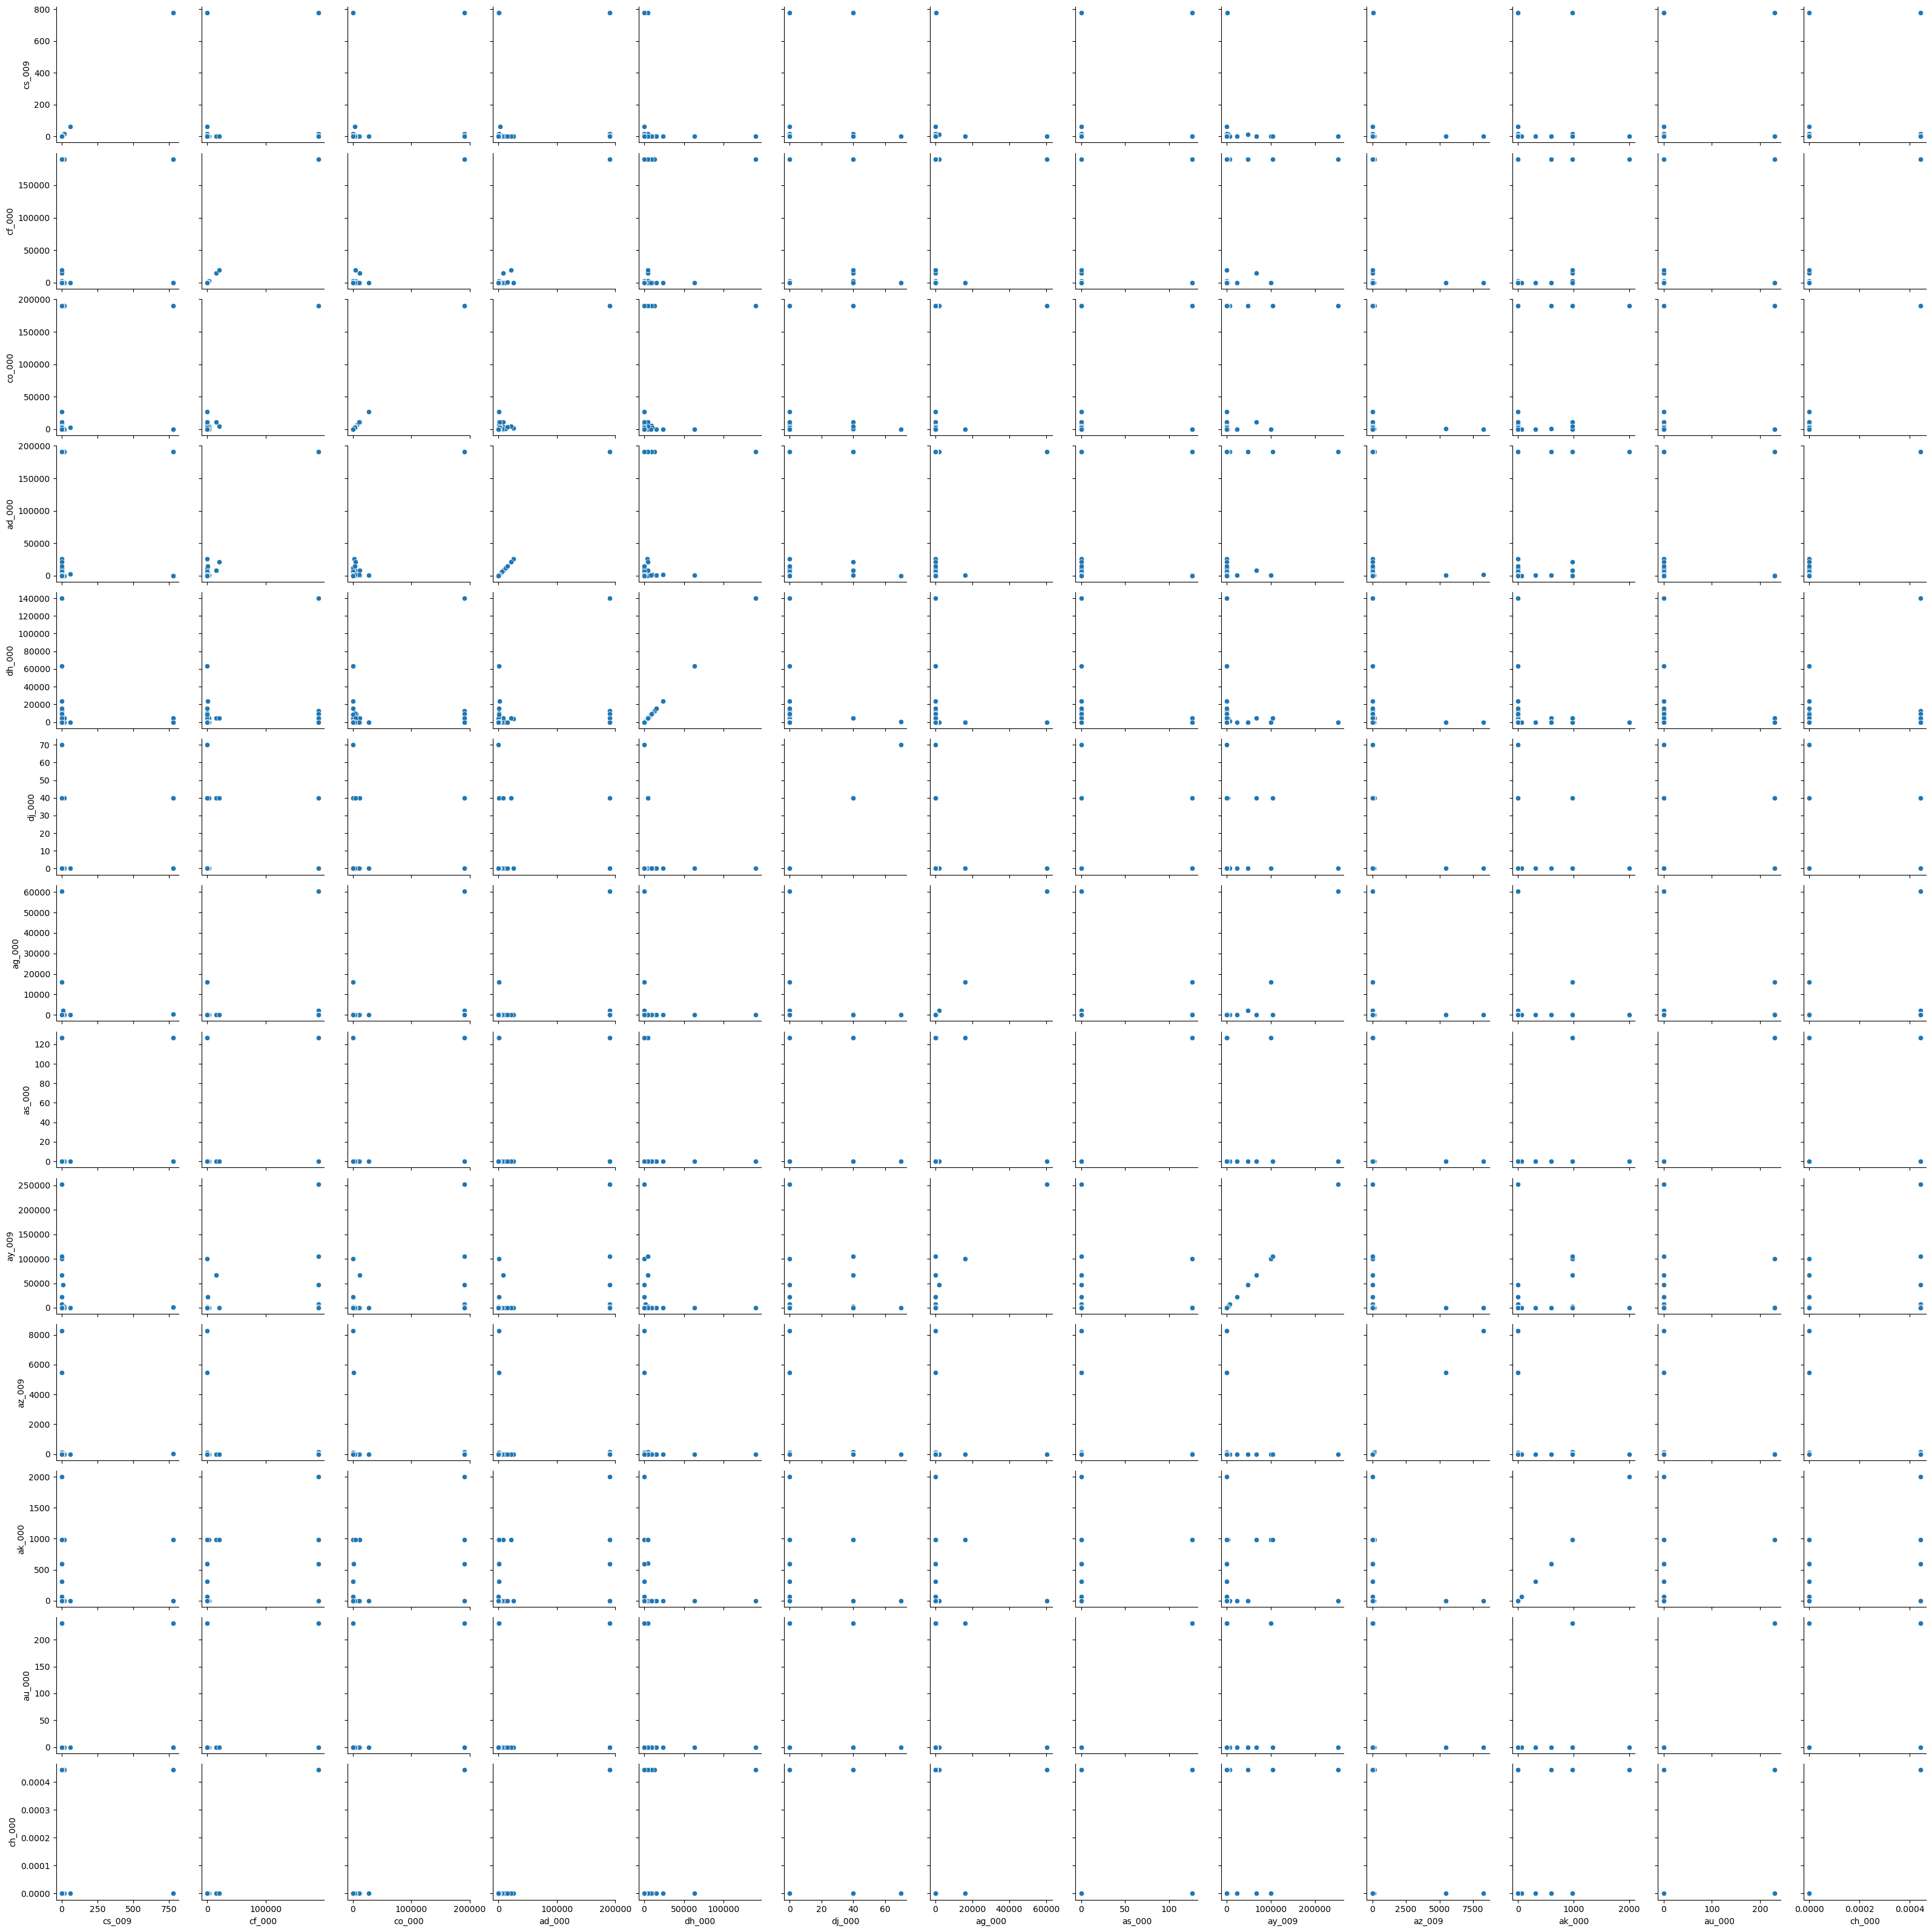

In [19]:
sample_data =  X_train_imputed[top_features].sample(n=1000, random_state=42)
sns.pairplot(sample_data, diag_kind=None)
plt.show()

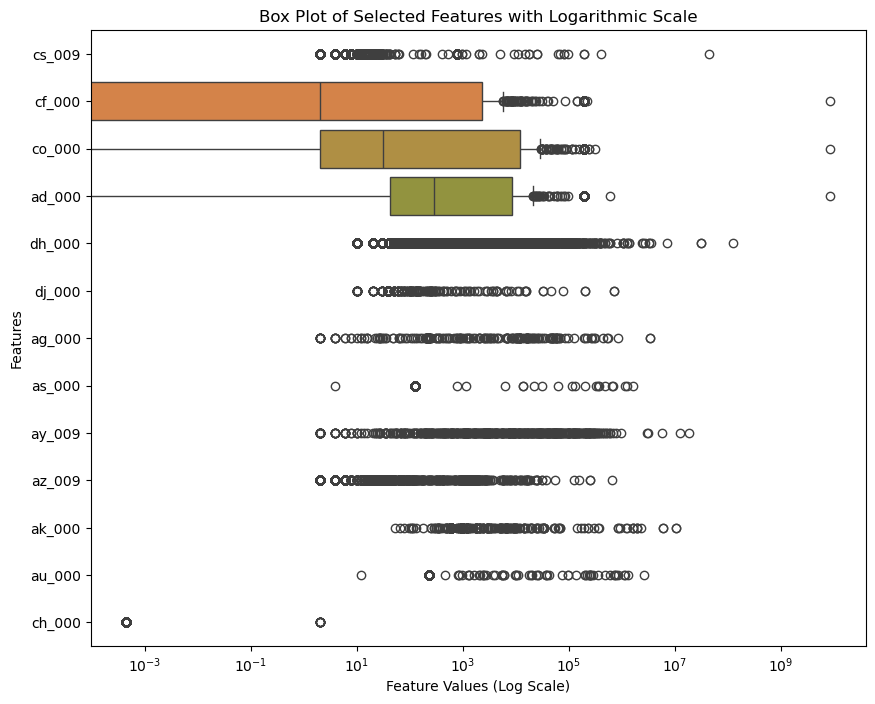

In [20]:
plt.figure(figsize=(10, 8))
box_plot = sns.boxplot(data= X_train_imputed[top_features], orient='h')


plt.xscale("log")
plt.title("Box Plot of Selected Features with Logarithmic Scale")
plt.xlabel("Feature Values (Log Scale)")
plt.ylabel("Features")
plt.show()

Conclusions:

1. From just the scatterplots, a conclusion cannot be drawn since not enough information can be extracted.
2. Outliers can affect the data points very quickly in this case because the mean is being used as an imputation strategy.


#### (v) Is this data set imbalanced?

In [23]:
pos_count = y_train.sum()
neg_count = len(y_train) - pos_count
print(f"Positive Cases: {pos_count}, Negative Cases: {neg_count}")

imbalance_ratio = pos_count / neg_count
print("Imbalance Ratio:", imbalance_ratio)

Positive Cases: 1000, Negative Cases: 59000
Imbalance Ratio: 0.01694915254237288


Conclusions:

1. The number of negative cases is way more than that of positive cases.
2. The data can be labeled **highly imbalanced** since the percentage of the positive class is 1000/60000 = 1.66667.

### (c) Train a random forest

In [26]:
def plot_roc_curve(true_labels, predicted_probabilities, dataset_name=""):
    plt.figure(figsize=(6, 4))
    plt.title(f"ROC Curve for {dataset_name}")
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC: {auc_score:.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [27]:
def evaluate_model(true_labels, predictions, probabilities, dataset_name=""):
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"{dataset_name} Confusion Matrix:\n{conf_matrix}\n")

    accuracy = accuracy_score(true_labels, predictions)
    error = 1 - accuracy
    print(f"{dataset_name} Accuracy: {accuracy:.5f}")
    print(f"{dataset_name} Misclassification Rate: {error:.5f}")

    auc_score = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"{dataset_name} ROC AUC Score: {auc_score:.5f}")

    display_roc(true_labels, probabilities, dataset_name)

In [28]:
def evaluate_model(true_labels, predictions, probabilities, dataset_name=""):
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"{dataset_name} Confusion Matrix:\n{conf_matrix}\n")

    accuracy = accuracy_score(true_labels, predictions)
    error = 1 - accuracy
    print(f"{dataset_name} Accuracy: {accuracy:.5f}")
    print(f"{dataset_name} Misclassification Rate: {error:.5f}")

    auc_score = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"{dataset_name} ROC AUC Score: {auc_score:.5f}")

    plot_roc_curve(true_labels, probabilities, dataset_name)

In [29]:
def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True)
    rf_model.fit(X_train, y_train)
    return rf_model

Training Confusion Matrix:
[[58976    24]
 [  432   568]]

Training Accuracy: 0.99240
Training Misclassification Rate: 0.00760
Training ROC AUC Score: 0.98624


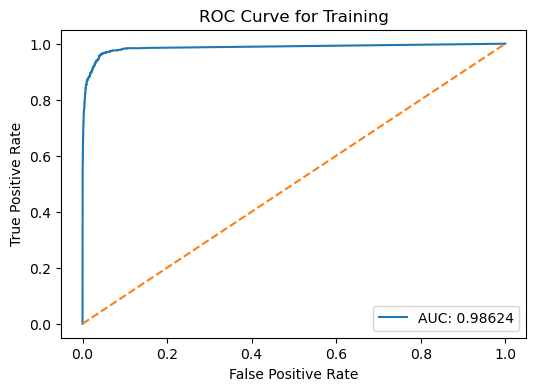

Testing Confusion Matrix:
[[15611    14]
 [  173   202]]

Testing Accuracy: 0.98831
Testing Misclassification Rate: 0.01169
Testing ROC AUC Score: 0.99414


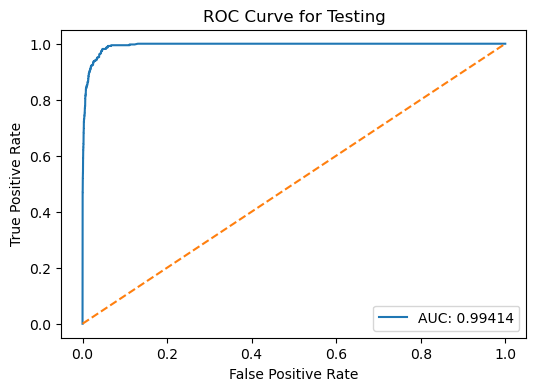

OOB Error Estimate: 0.00928
Test Error Rate: 0.01169


In [30]:
model = train_random_forest(X_train_imputed, y_train)

y_train_predicted = model.predict(X_train_imputed)
y_train_prob = model.predict_proba(X_train_imputed)
evaluate_model(y_train, y_train_predicted, y_train_prob, "Training")

y_test_predicted = model.predict(X_test_imputed)
y_test_prob = model.predict_proba(X_test_imputed)
evaluate_model(y_test, y_test_predicted, y_test_prob, "Testing")

train_oob_error = 1 - model.oob_score_
test_error = 1 - accuracy_score(y_test, y_test_predicted)
print(f"OOB Error Estimate: {train_oob_error:.5f}")
print(f"Test Error Rate: {test_error:.5f}")

Comparison:
1. Test error is approximately 25.97 percent higher than the OOB error estimate
2. Because there are fewer positive samples, the model predominantly focuses on the negative class. This leads to an increase in false negatives within the test set confusion matrix, which contributes to a higher overall test error compared to the training error.

### (d) Research class imbalance in random forest

To handle an imbalance in random forest we can use some methods like:


1. **RandomForestClassifier wit `class_weight='balance'`**: This option automatically assigns weights to each class based on their frequencies, such that the weight for each class is proportional to the inverse of its occurrence. If not specified, all classes are treated with equal weight. For problems with multiple outputs, a list of dictionaries can be used, with each dictionary corresponding to a column i y`.

2. **BalancedRandomForestClassifier**: This model is designed specifically for handling imbalanced datasets by performing random undersampling on each bootstrap sample, thereby reducing the effect of class imbalance.


In [34]:
def plot_roc_curve(true_labels, predicted_probabilities, dataset_name=""):
    plt.figure(figsize=(6, 4))
    plt.title(f"ROC Curve for {dataset_name}")
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities[:, 1])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC: {auc_score:.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [35]:
def evaluate_model(true_labels, predictions, probabilities, dataset_name=""):
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"{dataset_name} Confusion Matrix:\n{conf_matrix}\n")

    accuracy = accuracy_score(true_labels, predictions)
    error = 1 - accuracy
    print(f"{dataset_name} Accuracy: {accuracy:.5f}")
    print(f"{dataset_name} Misclassification Rate: {error:.5f}")

    auc_score = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"{dataset_name} ROC AUC Score: {auc_score:.5f}")

    plot_roc_curve(true_labels, probabilities, dataset_name)

Training (Balanced) Confusion Matrix:
[[56610  2390]
 [   31   969]]

Training (Balanced) Accuracy: 0.95965
Training (Balanced) Misclassification Rate: 0.04035
Training (Balanced) ROC AUC Score: 0.98997


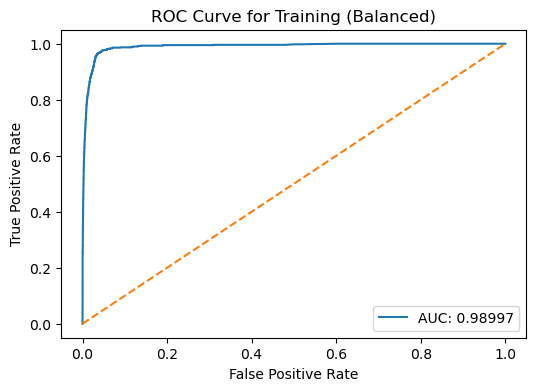

Testing (Balanced) Confusion Matrix:
[[15013   612]
 [   12   363]]

Testing (Balanced) Accuracy: 0.96100
Testing (Balanced) Misclassification Rate: 0.03900
Testing (Balanced) ROC AUC Score: 0.98982


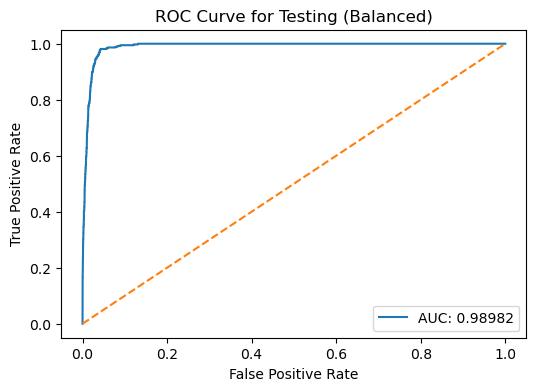

OOB Error Estimate (Balanced): 0.04157
Test Error Rate (Balanced): 0.03900


In [36]:
def train_random_forest_with_balance(X_train, y_train):
    rf_model = RandomForestClassifier(max_depth=5, random_state=42, oob_score=True, class_weight="balanced")
    rf_model.fit(X_train, y_train)
    return rf_model

balanced_model = train_random_forest_with_balance(X_train_imputed, y_train)

y_train_predicted_balanced = balanced_model.predict(X_train_imputed)
y_train_prob_balanced = balanced_model.predict_proba(X_train_imputed)
evaluate_model(y_train, y_train_predicted_balanced, y_train_prob_balanced, "Training (Balanced)")

y_test_predicted_balanced = balanced_model.predict(X_test_imputed)
y_test_prob_balanced = balanced_model.predict_proba(X_test_imputed)
evaluate_model(y_test, y_test_predicted_balanced, y_test_prob_balanced, "Testing (Balanced)")

train_oob_error_balanced = 1 - balanced_model.oob_score_
test_error_balanced = 1 - accuracy_score(y_test, y_test_predicted_balanced)
print(f"OOB Error Estimate (Balanced): {train_oob_error_balanced:.5f}")
print(f"Test Error Rate (Balanced): {test_error_balanced:.5f}")

 - The Testing Error is approximately 4.59% lower than the Train OOB Error.

   ***Findings***

    -For imbalanced data, the model achieves high overall accuracy by accurately predicting the majority (negative) class, which has around 59,000 data points. However, its performance on the minority (positive) class is quite poor.

   -When the classes are balanced, the model’s ability to predict the positive class improves significantly

### (e) XGBoost and Model Trees

In [39]:
def tune_xgb_classifier(X_train, y_train, param_grid):
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
   
    grid_search.fit(X_train, y_train)
    optimal_alpha = grid_search.best_params_['reg_alpha']
    return grid_search, optimal_alpha

In [40]:
def evaluate_classifier(X_train, y_train, X_test, y_test, optimal_alpha):
   
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        reg_alpha=optimal_alpha,
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    
    xgb_model.fit(X_train, y_train)
    
    
    y_train_pred = xgb_model.predict(X_train)
    y_train_prob = xgb_model.predict_proba(X_train)[:, 1]
    
    
    y_test_pred = xgb_model.predict(X_test)
    y_test_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    
    evaluation_stats = {
        "train": {
            "confusion_matrix": confusion_matrix(y_train, y_train_pred),
            "accuracy": accuracy_score(y_train, y_train_pred),
            "roc_auc": roc_auc_score(y_train, y_train_prob)
        },
        "test": {
            "confusion_matrix": confusion_matrix(y_test, y_test_pred),
            "accuracy": accuracy_score(y_test, y_test_pred),
            "roc_auc": roc_auc_score(y_test, y_test_prob)
        }
    }
    
    
    for set_name, (true_labels, prob_scores) in {"Training": (y_train, y_train_prob), "Testing": (y_test, y_test_prob)}.items():
        fpr, tpr, _ = roc_curve(true_labels, prob_scores)
        plt.plot(fpr, tpr, label=f'{set_name} ROC (AUC = {roc_auc_score(true_labels, prob_scores):.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    return evaluation_stats

Optimal alpha: 0.5
Best cross-validation accuracy: 0.9941


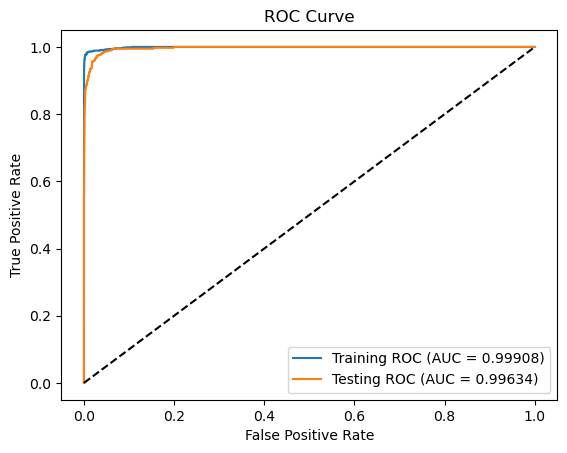

{'train': {'confusion_matrix': array([[58993,     7],
         [  101,   899]], dtype=int64),
  'accuracy': 0.9982,
  'roc_auc': 0.9990792288135594},
 'test': {'confusion_matrix': array([[15609,    16],
         [   93,   282]], dtype=int64),
  'accuracy': 0.9931875,
  'roc_auc': 0.9963419306666667},
 'best_alpha': 0.5}

In [41]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

param_grid = {
    "reg_alpha": [0.01, 0.05, 0.1, 0.2, 0.5]
}

grid_search, best_alpha = tune_xgb_classifier(X_train_scaled, y_train, param_grid)
print("Optimal alpha:", best_alpha)
print("Best cross-validation accuracy:", round(grid_search.best_score_, 5))

evaluation_results = evaluate_classifier(X_train_scaled, y_train, X_test_scaled, y_test, best_alpha)
evaluation_results["best_alpha"] = best_alpha

evaluation_results

### (f) Use SMOTE to pre-process your data

In [43]:
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
    print("Class distribution after applying SMOTE:")
    print(pd.Series(y_balanced).value_counts())
    return X_balanced, y_balanced

In [44]:
def perform_grid_search(X, y, param_grid):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBClassifier(
        objective='binary:logistic',
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_param = grid_search.best_params_['reg_alpha']
    print(f"Best alpha from grid search: {best_param}")
    return grid_search, best_param


In [45]:
def model_evaluation(X_train, y_train, X_test, y_test, alpha_value):
    model = XGBClassifier(
        objective='binary:logistic',
        reg_alpha=alpha_value,
        colsample_bytree=0.3,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    
    metrics = {}
    
    
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    metrics['train'] = {
        'conf_matrix': confusion_matrix(y_train, y_train_pred),
        'accuracy': round(accuracy_score(y_train, y_train_pred), 5),
        'misclass_rate': round(1 - accuracy_score(y_train, y_train_pred), 5),
        'roc_auc': round(roc_auc_score(y_train, y_train_prob), 5)
    }
    
    
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1]
    metrics['test'] = {
        'conf_matrix': confusion_matrix(y_test, y_test_pred),
        'accuracy': round(accuracy_score(y_test, y_test_pred), 5),
        'misclass_rate': round(1 - accuracy_score(y_test, y_test_pred), 5),
        'roc_auc': round(roc_auc_score(y_test, y_test_prob), 5)
    }
    plt.figure(figsize=(10, 5))
    
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {metrics["train"]["roc_auc"]:.5f})')
    
    
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {metrics["test"]["roc_auc"]:.5f})')
    
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    return metrics

Class distribution after applying SMOTE:
class
0    59000
1    59000
Name: count, dtype: int64
Best alpha from grid search: 0.01


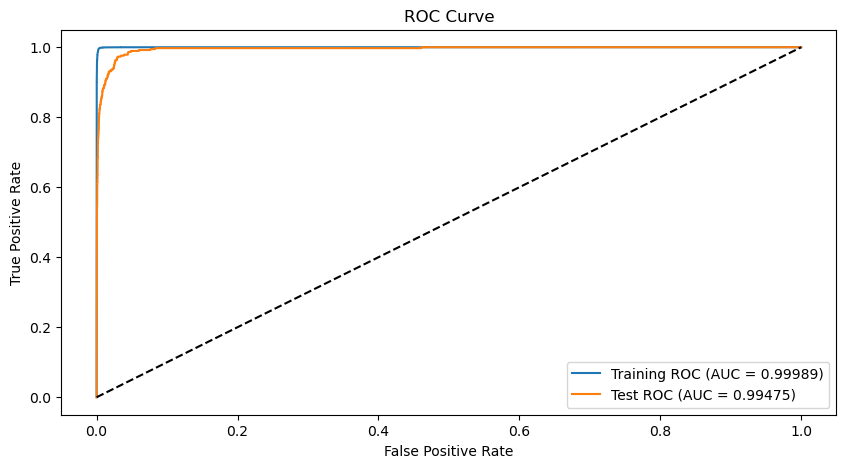

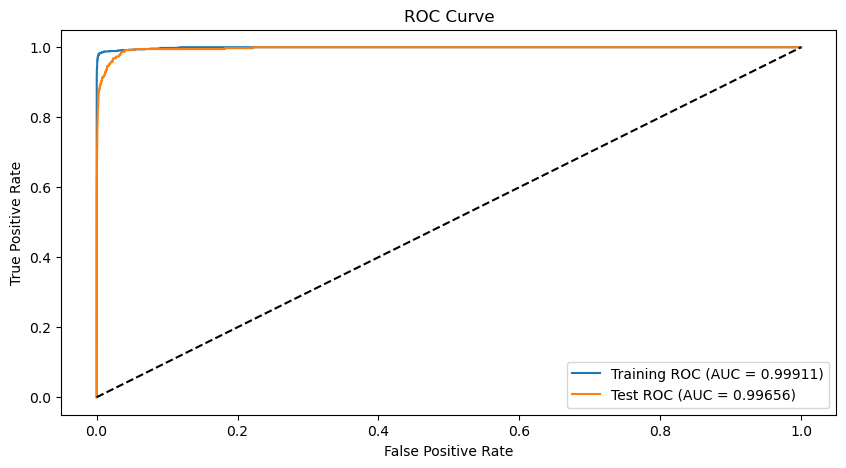

,Train Error,Train Accuracy,Train ROC AUC,Test Error,Test Accuracy,Test ROC AUC
Without SMOTE,0.00185,0.99815,0.99911,0.00656,0.99344,0.99656
With SMOTE,0.00390,0.99610,0.99989,0.01194,0.98806,0.99475


In [46]:
X_train_balanced, y_train_balanced = apply_smote(X_train_scaled, y_train)


param_grid = {"reg_alpha": [0.01, 0.05, 0.1, 0.2, 0.5]}
grid_results, optimal_alpha = perform_grid_search(X_train_balanced, y_train_balanced, param_grid)


metrics_with_smote = model_evaluation(X_train_balanced, y_train_balanced, X_test_scaled, y_test, optimal_alpha)


metrics_without_smote = model_evaluation(X_train_scaled, y_train, X_test_scaled, y_test, optimal_alpha)


comparison_data = {
    "Train Error": [metrics_without_smote['train']['misclass_rate'], metrics_with_smote['train']['misclass_rate']],
    "Train Accuracy": [metrics_without_smote['train']['accuracy'], metrics_with_smote['train']['accuracy']],
    "Train ROC AUC": [metrics_without_smote['train']['roc_auc'], metrics_with_smote['train']['roc_auc']],
    "Test Error": [metrics_without_smote['test']['misclass_rate'], metrics_with_smote['test']['misclass_rate']],
    "Test Accuracy": [metrics_without_smote['test']['accuracy'], metrics_with_smote['test']['accuracy']],
    "Test ROC AUC": [metrics_without_smote['test']['roc_auc'], metrics_with_smote['test']['roc_auc']]
}


df_comparison = pd.DataFrame(comparison_data, index=["Without SMOTE", "With SMOTE"])
df_comparison

References:
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html


https://numpy.org/doc/stable/reference/generated/numpy.mean.html


https://numpy.org/doc/stable/reference/generated/numpy.std.html


https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions


https://www.statsmodels.org/stable/index.html


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html


https://scikit-learn.org/stable/modules/feature_selection.html


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html


https://seaborn.pydata.org/generated/seaborn.boxplot.html


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html


https://pandas.pydata.org/docs/reference/api/pandas.Series.sum.html


https://docs.python.org/3/library/functions.html#len


https://scikit-learn.org/dev/modules/generated/sklearn.metrics.roc_curve.html


https://scikit-learn.org/dev/modules/generated/sklearn.metrics.auc.html


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html


https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html


https://scikit-learn.org/stable/getting_started.html


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html


https://scikit-learn.org/stable/search.html?q=predict_proba


https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html


https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html


https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html


https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier


https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters


https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html


https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html


https://imbalanced-learn.org/stable/references/generated/imblelrn.over_sampling.SMOTE.html


https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

ction.GridSearchCV.html

